In [3]:
import torch
from sklearn.metrics import mean_squared_error
from sbi.analysis import pairplot
from sbi.inference import NPE
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from sbi.inference.potentials import posterior_estimator_based_potential
from sbi.samplers.rejection import rejection
from sbi.utils.user_input_checks import process_prior as sbi_process_prior


from simglucose.simulation.env import T1DSimEnv
from simglucose.controller.basal_bolus_ctrller import BBController
from simglucose.sensor.cgm import CGMSensor
from simglucose.actuator.pump import InsulinPump
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.simulation.scenario_gen import RandomScenario
from simglucose.simulation.scenario import CustomScenario
from simglucose.simulation.sim_engine import SimObj, sim, batch_sim
from datetime import timedelta
from datetime import datetime
from torch.distributions import Distribution 

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import time
from torch.distributions import MultivariateNormal
from dataclasses import dataclass, fields, field

c:\Users\bythe\Desktop\Glucose Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
print(torch.__version__)
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print('CUDA available')
    print(torch.cuda.get_device_name(0))
    device = torch.device('cuda')   
    print(device)

2.6.0+cu126
True
CUDA available
NVIDIA GeForce GTX 1660 SUPER
cuda


In [5]:
pathos = True
try:
    from pathos.multiprocessing import ProcessPool as Pool
except ImportError:
    print('You could install pathos to enable parallel simulation.')
    pathos = False

In [6]:
@dataclass
class ParamPriors:
    kmax: tuple = (0.01, 0.1)
    kmin: tuple = (0.0, 0.05)
    b: tuple = (0.5, 1.0)
    d: tuple = (0.05, 0.5)
    kabs: tuple = (0.01, 1.5)
    kp1: tuple = (3.0, 12.0)
    kp2: tuple = (0.0, 0.05)
    kp3: tuple = (0.0, 0.05)
    k1: tuple = (0.01, 0.2)
    k2: tuple = (0.01, 0.5)
    Vm0: tuple = (1.0, 15.0)
    Vmx: tuple = (0.01, 0.2)
    ka1: tuple = (0.001, 0.01)
    ka2: tuple = (0.01, 0.05)
    m1: tuple = (0.1, 0.5)
    m2: tuple = (0.1, 0.5)
    m30: tuple = (0.1, 1.0)
    m4: tuple = (0.05, 0.2)
    ki: tuple = (0.0, 0.05)
    p2u: tuple = (0.01, 0.1)
    Ib: tuple = (80.0, 140.0)
    kd: tuple = (0.01, 0.03)
    ksc: tuple = (0.05, 0.2)
print('n_params = ', len(fields(ParamPriors)))

n_params =  23


In [7]:
def get_patient_params(env):
    param_names = [f.name for f in fields(ParamPriors)]
    params = [getattr(env.env.patient._params, param) for param in param_names]
    return dict(zip(param_names, params))

In [8]:
@dataclass
class DeafultSimulationEnv:
   patient_name: str = 'adolescent#002'
   sensor_name: str = 'Dexcom'
   pump_name: str = 'Insulet'
   scenario: list[tuple[int,int]] = field(default_factory=lambda: [(7, 45), (12, 70), (16, 15), (18, 80), (23, 10)])
   hours: int = 24  # hours to simulate

In [9]:
priors = ParamPriors()

priors = ParamPriors()

# get the names and default values of the parameters using fields
param_names = [field.name for field in fields(priors)]
param_values = [field.default for field in fields(priors)]

print(param_names)
print(param_values)

['kmax', 'kmin', 'b', 'd', 'kabs', 'kp1', 'kp2', 'kp3', 'k1', 'k2', 'Vm0', 'Vmx', 'ka1', 'ka2', 'm1', 'm2', 'm30', 'm4', 'ki', 'p2u', 'Ib', 'kd', 'ksc']
[(0.01, 0.1), (0.0, 0.05), (0.5, 1.0), (0.05, 0.5), (0.01, 1.5), (3.0, 12.0), (0.0, 0.05), (0.0, 0.05), (0.01, 0.2), (0.01, 0.5), (1.0, 15.0), (0.01, 0.2), (0.001, 0.01), (0.01, 0.05), (0.1, 0.5), (0.1, 0.5), (0.1, 1.0), (0.05, 0.2), (0.0, 0.05), (0.01, 0.1), (80.0, 140.0), (0.01, 0.03), (0.05, 0.2)]


In [10]:
def process_uniform_priors(priors: ParamPriors) -> Distribution:
    """
    Create a single 23-dimensional Uniform prior:
        BoxUniform(low=(..., ..., ...), high=(..., ..., ...))
    """
    # 1) Gather lower and upper bounds
    low_vals = []
    high_vals = []
    for f in fields(priors):
        low, high = f.default  # e.g. (0.01, 0.1)
        low_vals.append(low)
        high_vals.append(high)

    # 2) Convert to Torch tensors on the GPU (if available)
    low_tensor = torch.tensor(low_vals, dtype=torch.float32, device=device)
    high_tensor = torch.tensor(high_vals, dtype=torch.float32, device=device)

    # 3) Create a single 23D BoxUniform distribution
    return BoxUniform(low=low_tensor, high=high_tensor, device=device)


In [14]:
processed_priors = process_uniform_priors(priors)
print(processed_priors)

BoxUniform(Uniform(low: torch.Size([23]), high: torch.Size([23])), 1)


In [32]:
prior_sample = processed_priors.sample(sample_shape=(1,))

In [33]:
print(prior_sample)

tensor([[8.9359e-02, 2.0366e-02, 9.8051e-01, 4.0114e-01, 7.5034e-02, 3.0893e+00,
         1.4568e-02, 4.8781e-02, 8.5510e-02, 4.3113e-01, 1.2773e+01, 1.6878e-01,
         9.2315e-03, 1.5337e-02, 2.8679e-01, 4.8024e-01, 2.1851e-01, 1.9773e-01,
         3.9992e-02, 3.2478e-02, 9.6435e+01, 2.6336e-02, 1.2642e-01]],
       device='cuda:0')


In [34]:
for i in range(23):
    print(f'{param_names[i]}: {prior_sample[0, i]:.3f}')

kmax: 0.089
kmin: 0.020
b: 0.981
d: 0.401
kabs: 0.075
kp1: 3.089
kp2: 0.015
kp3: 0.049
k1: 0.086
k2: 0.431
Vm0: 12.773
Vmx: 0.169
ka1: 0.009
ka2: 0.015
m1: 0.287
m2: 0.480
m30: 0.219
m4: 0.198
ki: 0.040
p2u: 0.032
Ib: 96.435
kd: 0.026
ksc: 0.126


In [22]:
def load_default_simulation_env(env_settings: DeafultSimulationEnv = DeafultSimulationEnv(), hours:int =24) -> T1DSimEnv:
    """Load the default simulation environment.

    Parameters
    ----------
    env_settings : DeafultSimulationEnv
        DataClass object containing the default simulation environment settings.

    Returns
    -------
    T1DSimEnv
        The simulation environment object.
    """
    now = datetime.now()
    start_time = datetime.combine(now.date(), datetime.min.time())
    
    patient = T1DPatient.withName(env_settings.patient_name)
    sensor = CGMSensor.withName(env_settings.sensor_name, seed = 1)
    pump = InsulinPump.withName(env_settings.pump_name)
    scenario = CustomScenario(start_time=start_time, scenario=env_settings.scenario)
    controller = BBController()
    env = T1DSimEnv(patient=patient, sensor=sensor, pump=pump, scenario=scenario)
    
    return SimObj(env = env, controller = controller, sim_time = timedelta(hours=hours), animate=False)

In [48]:
def set_custom_params(patient, custom_params):
    """_summary_

    Parameters
    ----------
    patient : _type_
        _description_
    custom_params : _type_
        _description_
    """
    # convert tensor to list
    custom_params = custom_params.tolist()  
    #print(custom_params)
    param_names = [field.name for field in fields(ParamPriors())]
    for i, param in enumerate(param_names):
        setattr(patient._params, param, custom_params[i])

In [24]:
def create_simulation_envs_with_custom_params(params_sets: torch.Tensor, hours: int = 24):
    # Now params_sets.shape is (N, 23)
    default_simulation_env = load_default_simulation_env(hours=hours)
    simulation_envs = []
    for i in range(params_sets.shape[0]):
        custom_sim_env = deepcopy(default_simulation_env)
        # row i is shape (23,)
        set_custom_params(custom_sim_env.env.patient, params_sets[i])
        simulation_envs.append(custom_sim_env)
    return simulation_envs


        
    

In [25]:
def simulate_glucose_dynamics(simulation_env: T1DSimEnv):
    """_summary_

    Parameters
    ----------
    simulation_env : T1DSimEnv
        _description_

    Returns
    -------
    _type_
        _description_
    """
    simulation_env.simulate()
    return simulation_env.results()['CGM'].values

In [26]:
def simulate_batch(simulations: list[T1DSimEnv]):
    """_summary_

    Parameters
    ----------
    simulations : list[T1DSimEnv]
        _description_

    Returns
    -------
    _type_
        _description_
    """
    tic = time.time()
    if pathos:
        with Pool() as p:
            print('Using pathos for parallel simulation.')
            results = p.map(simulate_glucose_dynamics, simulations)
    else:
        results = [simulate_glucose_dynamics(s) for s in tqdm(simulations)]
    toc = time.time()
    print('Simulation took {} sec.'.format(toc - tic))
    results = np.stack(results)
    results = torch.from_numpy(results).float().to(device)
    return results

In [27]:
def run_glucose_simulator(params_sets: torch.Tensor, hours: int = 24):
    # Suppose params_sets is (N, 23)
    simulation_envs = create_simulation_envs_with_custom_params(params_sets)
    results = simulate_batch(simulation_envs)
    return results


In [28]:
def set_up_sbi_simulator(
    priors: ParamPriors = ParamPriors(),
    glucose_simulator: callable = run_glucose_simulator,
) -> callable:
    processed_priors = process_uniform_priors(priors=priors)  # 23D BoxUniform
    sbi_sumulator = process_simulator(glucose_simulator, processed_priors, is_numpy_simulator=True)
    check_sbi_inputs(sbi_sumulator, processed_priors)  # optional
    return sbi_sumulator

In [29]:
def get_true_observation(hours: int = 24) -> tuple[np.ndarray, dict]:
    """ Returns the single glucose dynamcis simulation from the default simulation environment parameters and these parameters.

    Returns
    -------
    np.ndarray
        Time series of glucose dynamics.
    """
    default_simulation_env = load_default_simulation_env(hours=hours)
    default_simulation_env.simulate()
    true_params = get_patient_params(default_simulation_env)
    true_observation = default_simulation_env.results()['CGM'].to_numpy()
    true_observation = torch.from_numpy(true_observation).float().to(device)
    return true_observation, true_params

In [30]:


def run_APT(
    prior: torch.distributions.Distribution,
    simulator: callable,
    true_observation: torch.Tensor,
    num_rounds: int = 10,
    num_simulations: int = 1000,
):
    """
    Run Amortized Posterior Training (APT) with NPE on a GPU if available.
    """
    # We already have a global device:
    print(f"Using device: {device}")

    # Initialize NPE on device
    inference = NPE(prior=prior, device=device)

    proposal = prior  # start with prior

    for r in range(num_rounds):
        print(f"Running round {r + 1} of {num_rounds}")

        theta = proposal.sample((num_simulations,))
        # simulator returns x on GPU due to our modifications
        x = simulator(theta)

        # Optional sanity check: ensure on same device
        theta = theta.to(device)
        x = x.to(device)

        # Train
        _ = inference.append_simulations(theta, x, proposal=proposal).train()

        # Build posterior and condition on true_observation
        posterior_dist = inference.build_posterior().set_default_x(true_observation)

        # Next round
        proposal = posterior_dist

    return posterior_dist



In [41]:
sbi_simulator = set_up_sbi_simulator()

[0.08022686839103699, 0.01534718181937933, 0.7747467756271362, 0.1714082956314087, 1.0225948095321655, 7.762775421142578, 0.02895953692495823, 0.02154812216758728, 0.14692412316799164, 0.3637492060661316, 8.942407608032227, 0.022912032902240753, 0.007242041639983654, 0.04318724572658539, 0.3221611976623535, 0.2245689332485199, 0.6784731149673462, 0.11015482991933823, 0.04491179436445236, 0.0815168172121048, 132.7985382080078, 0.02196064405143261, 0.19318293035030365]
[0.048327408730983734, 0.04996241256594658, 0.6503812670707703, 0.37073931097984314, 0.3943270444869995, 8.715044021606445, 0.01362327765673399, 0.03228966146707535, 0.12298351526260376, 0.4201231896877289, 1.9579542875289917, 0.11012254655361176, 0.005105735268443823, 0.012576421722769737, 0.3443276882171631, 0.2402498722076416, 0.3112614154815674, 0.18996569514274597, 0.04893042519688606, 0.0359313003718853, 131.40127563476562, 0.01087245438247919, 0.125367671251297]
Using pathos for parallel simulation.
Simulation took 

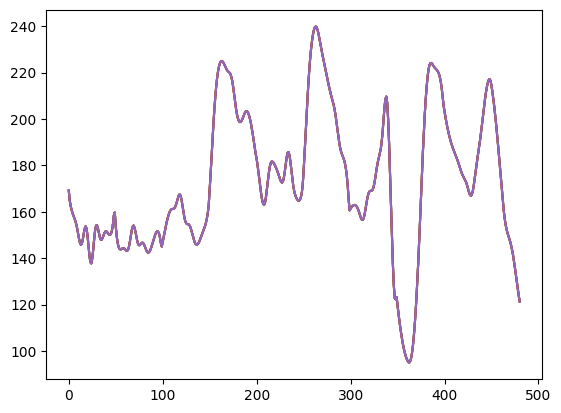

In [43]:
for i in range(5):
    true_observation, true_params = get_true_observation(hours = 24)
    
    # move to cpu
    true_observation = true_observation.cpu()
    
    plt.plot(true_observation)

In [44]:
def sample_from_posterior(posterior: Distribution, x_true: np.ndarray, num_samples: int = 1000) -> torch.Tensor: 
    posterior_samples = posterior.sample((num_samples,), x=x_true)
    return posterior_samples

In [46]:
prior = process_uniform_priors(priors)

In [ ]:
posterior_dist = run_APT(prior, sbi_simulator, true_observation, num_rounds = 5, num_simulations = 200)

Using device: cuda
Running round 1 of 5
Using pathos for parallel simulation.
Simulation took 165.40543222427368 sec.


c:\Users\bythe\Desktop\Glucose Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
c:\Users\bythe\Desktop\Glucose Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


 Neural network successfully converged after 157 epochs.Running round 2 of 5


Drawing 200 posterior samples: 209it [00:00, 405.03it/s]                         


Using pathos for parallel simulation.
Simulation took 180.7851836681366 sec.
Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 3

c:\Users\bythe\Desktop\Glucose Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
c:\Users\bythe\Desktop\Glucose Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


 Neural network successfully converged after 64 epochs.Running round 3 of 5


Drawing 200 posterior samples: 100%|██████████| 200/200 [02:22<00:00,  1.40it/s]


Using pathos for parallel simulation.
Simulation took 149.76222109794617 sec.
Using SNPE-C with atomic loss


c:\Users\bythe\Desktop\Glucose Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
c:\Users\bythe\Desktop\Glucose Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


 Neural network successfully converged after 93 epochs.Running round 4 of 5


Drawing 200 posterior samples: 100%|██████████| 200/200 [1:36:11<00:00, 28.86s/it]  


Using pathos for parallel simulation.
Simulation took 149.73849487304688 sec.
Using SNPE-C with atomic loss


c:\Users\bythe\Desktop\Glucose Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
c:\Users\bythe\Desktop\Glucose Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


 Neural network successfully converged after 40 epochs.Running round 5 of 5


Drawing 200 posterior samples:   0%|          | 1/200 [00:06<00:34,  5.75it/s]